### Tarea 3

#### Sección 3

In [1]:
import csv
import os
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

Cargamos el conjunto de datos como una listas de listas.

In [2]:
path = os.path.join('..','Datasets','GLT_filtrado.csv')

conjunto = [[],[],[],[],[],[],[]]

with open(path, 'r') as f:
    data = list(csv.reader(f))

    labels = data[0]

    for i in data[1:]:
        conjunto[0].append(i[0] if i[0]!='' else np.nan)
        conjunto[1].append(float(i[1]) if i[1]!='' else np.nan)
        conjunto[2].append(float(i[2]) if i[2]!='' else np.nan)
        conjunto[3].append(i[3] if i[3]!='' else np.nan)
        conjunto[4].append(i[4] if i[4]!='' else np.nan)
        conjunto[5].append(i[5] if i[5]!='' else np.nan)
        conjunto[6].append(i[6] if i[6]!='' else np.nan)

Contestemos las siguientes preguntas:

* ¿Tipo de dato de los atributos? <--- FALTA!!
* ¿Cuántas entradas hay?
* ¿Cuántas ciudades distintas?

In [3]:
# Total de datos
total = len(data[1:])
print(f'Total de datos: {total}')

# El índice 3 de `conjunto`` corresponde a las ciudades
ciudades_unicas = np.unique(conjunto[3])
print(f"Tenemos {len(ciudades_unicas)} ciudades únicas.")

Total de datos: 219575
Tenemos 100 ciudades únicas.


¿Cuantos valores faltantes hay en el atributo AverageTemperature?

In [4]:
# El índice 1 de `conjunto` corresponde a AverageTemperature
faltan = np.count_nonzero(np.isnan(conjunto[1]))
print(f"Hay {faltan} valores faltantes en el atributo 'AverageTemperature'.")
print(f"Los datos faltantes representan el {faltan*100/total:.2f}%")
print('-'*80)

# Verificamos valores faltantes para los demás atributos
for i in range(7):
    if i==1:
        continue
    print(f"Hay {np.count_nonzero(pd.isna(conjunto[i]))} valores faltantes en el atributo '{labels[i]}'")   # pd.isna() para que no haya error en la iteración

Hay 27581 valores faltantes en el atributo 'AverageTemperature'.
Los datos faltantes representan el 12.56%
--------------------------------------------------------------------------------
Hay 0 valores faltantes en el atributo 'Date'
Hay 27581 valores faltantes en el atributo 'AverageTemperatureUncertainty'
Hay 0 valores faltantes en el atributo 'City'
Hay 0 valores faltantes en el atributo 'Country'
Hay 0 valores faltantes en el atributo 'Latitude'
Hay 0 valores faltantes en el atributo 'Longitude'


Como vemos, los valores faltantes para AverageTemperature (así como para AverageTemperatureUncertainty) representan el 12.56%

En primera instancia no sabemos la ubicación de los valores faltantes en el conjunto de datos, es decir, hasta este punto no sabemos a qué fechas y/o ciudades les están faltando valores. El porcentaje que representan los valores faltantes es significativo pues afecta la distribución de la temperatura generando una importante dispersión en los datos. Se espera que esta distribución sea continua y suave en el tiempo pues esta es la naturaleza física del cambio en temperatura, es decir, sin saltos abruptos. Por ello, necesitamos aplicar una estrategia que nos permita rellenar de forma coherente los huecos faltantes para reducir el sesgo y dispersión, la cual se verá a continuación.

La estrategia que se tomará es tal que si falta algún dato dado un arreglo de temperaturas $$[T1,\; T2,\; T3, ...]$$ donde cada entrada representa la temperatura en un tiempo dado que a su vez está ordenado de izquierda a derecha temporalmente de forma creciente, este dato se calculará con la media aritmética entre el dato antecedente y sucesivo más proximo: $$[T1,\; \text{NaN},\; T3,\; ...] \rightarrow [T1,\; \frac{T1+T3}{2},\; T3, ...] $$

El llenado de datos vacíos se hará de izquierda a derecha de forma iterativa: $$[T1,\; \text{NaN},\;\text{NaN},\; T4,\; ...] \rightarrow [T1,\; \frac{T1+T4}{2},\;\frac{\frac{T1+T4}{2}+T4}{2},\; T4, ...]$$

Si el dato faltante está al inicio del arreglo se considerará que hay un dato antecedente de valor cero antes de este: $$[\text{Nan},\;T2,\;T3,...] \rightarrow [\frac{0+T2}{2},\;T2,\;T3,...]$$

Si el dato faltante está al final del arreglo se considerará que hay un dato sucesivo de valor cero después de este: $$[...,\;T5,\;\text{NaN}] \rightarrow [...,\; T5,\;\frac{T5+0}{2}]$$

In [5]:
def llenar_faltantes(ar: ArrayLike) -> list[float]:
    """
    La función toma un arreglo y llena cualquier vacío (NaN) con la media aritmética entre la medición antecedente más cercana y la medición sucesiva más cercana.
    La función recorre el arreglo de izquierda a derecha. 
    En caso de que un valor NaN esté al inicio (final) del arreglo, se considera que a dicho valor le antecede (sigue) el valor 0 y se calcula la media con dicho valor.

    :param ar: Arreglo de una dimensión

    :return: Lista
    """
    ar_copy = list(ar)
    
    for i,_ in enumerate(ar_copy):
        if np.isnan(ar_copy[i]):
            if i == 0:
                anterior = 0
            else: 
                anterior = ar_copy[i-1]

            j = i
            while np.isnan(ar_copy[j]):
                if j == len(ar_copy)-1:
                    siguiente = 0
                    break
                else:
                    siguiente = ar_copy[j+1]
                    j+=1

            prom = (anterior + siguiente) / 2
            ar_copy[i] = prom
    
    return ar_copy

Probamos la función:

- Primer ejemplo:

    - La lista inicial es:
    ```python
        [ np.nan, 5, 6, np.nan ]
    ```
    - La lista final debe ser:
    ```python
        [ 2.5, 5, 6, 3 ]
    ```
- Segundo ejemplo:

    - La lista inicial es:
    ```python
        [ np.nan, np.nan, 24, 28.9 ]
    ```
    - La lista final debe ser: 
    ```python
        [ 12.0, 18.0, 24, 28.9 ]
    ```

> Nota: La función itera sobre cada elemento del arreglo para buscar valores NaN. Esto es un proceso tardado cuando se trata de arreglos grandes. Como solución se pueden obtener solamente los índices en donde hay valores NaN e iterar sobre estos. Esto se puede realizar con ``` np.where(np.isnan(Array))[0] ``` <br> Esta es una implementación a realizar que por tiempos de la presente entrega no se hará ahora.

Se realiza una prueba para verificar el correcto funcionamiento de la funnción.

In [6]:
q_1 = [ np.nan, 5, 6, np.nan ]
q_2 = [ np.nan, np.nan, 24, 28.9 ]

Q_1 = llenar_faltantes(q_1)
Q_2 = llenar_faltantes(q_2)

print(f"""
      Lista original --> lista final
    {q_1} --> {Q_1}
{q_2} --> {Q_2}
""")


      Lista original --> lista final
    [nan, 5, 6, nan] --> [2.5, 5, 6, 3.0]
[nan, nan, 24, 28.9] --> [12.0, 18.0, 24, 28.9]



Aplicamosa ahora la función `llenar_faltantes` al conjunto de datos `conjunto[1]` que corresponde a `AverageTemperature`

In [7]:
AverageTemperature_full = np.array(llenar_faltantes(conjunto[1]))

#### Sección 4

##### 4.1

Encuentra la temperatura más caliente y más fría en estas ciudades: Cairo, Moscow, Peking, Rome, Mexico.

In [8]:
# El índice 3 de `conjunto` corresponde a City

''' Cairo '''
cairo_idx = np.where(np.array(conjunto[3])=='Cairo')[0]
cairo_temp = AverageTemperature_full[cairo_idx]

''' Moscow '''
moscow_idx = np.where(np.array(conjunto[3])=='Moscow')[0]
moscow_temp = AverageTemperature_full[moscow_idx]

''' Peking '''
peking_idx = np.where(np.array(conjunto[3])=='Peking')[0]
peking_temp = AverageTemperature_full[peking_idx]

''' Rome '''
rome_idx = np.where(np.array(conjunto[3])=='Rome')[0]
rome_temp = AverageTemperature_full[rome_idx]

''' México '''
mexico_idx = np.where(np.array(conjunto[3])=='Mexico')[0]
mexico_temp = AverageTemperature_full[mexico_idx]

In [9]:
markdown_text = f"""

| Ciudad       | Temperatura Mínima     | Temperatura Máxima     |
|--------------|------------------------|------------------------|
| Cairo        | {np.min(cairo_temp)}   | {np.max(cairo_temp)}   |
| Moscow       | {np.min(moscow_temp)}  | {np.max(moscow_temp)}  |
| Peking       | {np.min(peking_temp)}  | {np.max(peking_temp)}  |
| Rome         | {np.min(rome_temp)}    | {np.max(rome_temp)}    |
| México       | {np.min(mexico_temp)}  | {np.max(mexico_temp)}  |

"""

display(Markdown(markdown_text))



| Ciudad       | Temperatura Mínima     | Temperatura Máxima     |
|--------------|------------------------|------------------------|
| Cairo        | 10.326   | 30.767   |
| Moscow       | -19.376  | 24.58  |
| Peking       | -8.579  | 28.936  |
| Rome         | -1.4410000000000005    | 25.951    |
| México       | 9.127  | 21.0  |



##### 4.2

Hay una anomalía en la distribución de datos. Con la ayuda de Matplotlib, grafica la distribución de las temperaturas medias terrestres para Roma y Bangkok.

> El número de bins se calcula  automáticamente con la opción `bins = 'auto'` <br>
> Referencia: https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html

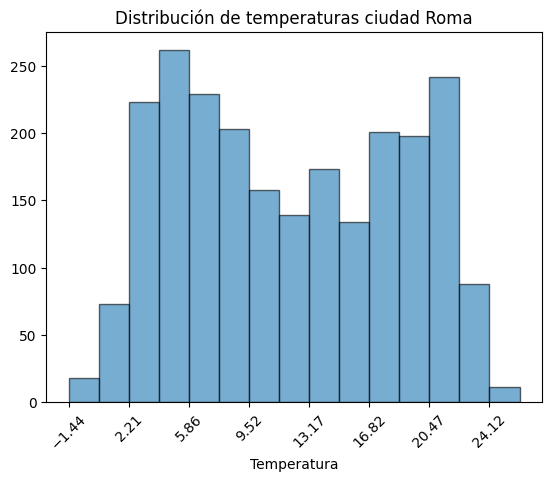

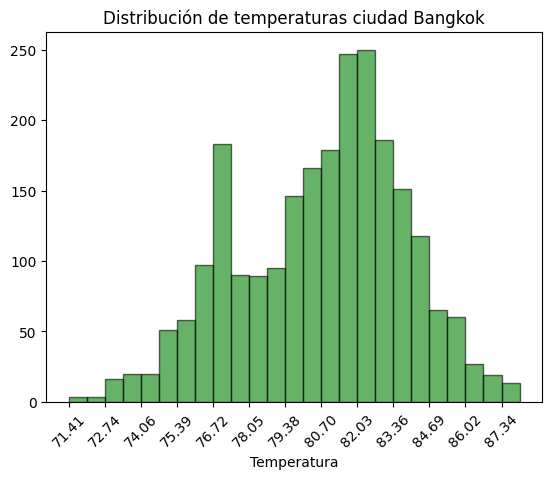

In [10]:
''' Bangkok '''
bangkok_idx = np.where(np.array(conjunto[3])=='Bangkok')[0]
bangkok_temp = AverageTemperature_full[bangkok_idx]

color = ('Black', 0.6)
bins_rome = np.histogram_bin_edges(rome_temp, bins='auto')
plt.hist(rome_temp, bins=bins_rome, edgecolor=color[0], alpha=color[1])
plt.title('Distribución de temperaturas ciudad Roma')
plt.xlabel('Temperatura')
plt.xticks(bins_rome[::2], rotation=45)
plt.show()

bins_bangkok = np.histogram_bin_edges(bangkok_temp, bins='auto')
plt.hist(bangkok_temp, bins=bins_bangkok, color='green', edgecolor=color[0], alpha=color[1])
plt.title('Distribución de temperaturas ciudad Bangkok')
plt.xlabel('Temperatura')
plt.xticks(bins_bangkok[::2], rotation=45)
plt.show()

##### 4.3  Falta explicación

Como puedes ver, Roma y Bangkok tienen distribuciones de temperatura muy diferentes. Sin embargo, lo que resulta extraño es la gran diferencia en la magnitud de sus temperaturas. Es posible que todos los sensores de las
estaciones de Bangkok estuvieran defectuosos? Qué crees que pudo haber sucedido aquí? Hay otras ciudades que presentan el mismo problema? Usa tu creatividad para analizarlo y proponer una explicación.

El registro de temperaturas está en °F.
Tener temperaturas por encima de 70 °C es demasiado.

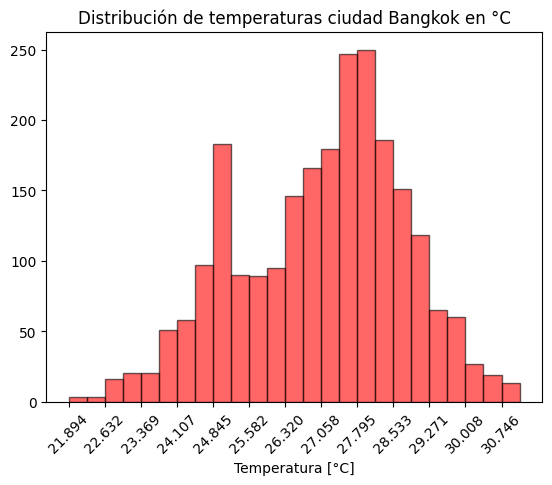

In [ ]:
bangkok_temp_C = (5/9)*(bangkok_temp - 32)

# Sobrescribimos las temperaturas de Bangkok ya corregidas 
AverageTemperature_full[bangkok_idx] = bangkok_temp_C

bins_bangkok_C = np.histogram_bin_edges(bangkok_temp_C, bins='auto')
plt.hist(bangkok_temp_C, bins=bins_bangkok_C, color='red', edgecolor=color[0], alpha=color[1])
plt.title('Distribución de temperaturas ciudad Bangkok en °C')
plt.xlabel('Temperatura [°C]')
plt.xticks(bins_bangkok_C[::2], rotation=45)
plt.show()

Para revisar si hay otras ciudades presentando el mismo problema basta con encontrar el máximo del conjunto de temperaturas en el que no se considere a Bangkok. Si dentro del conjunto la temperatura más alta es razonable en unidades °C entonces no habrá otra ciudad dentro del conjunto de datos que esté en °F.

In [12]:
# Índices donde no está Bangkok
idx = np.where(np.array(conjunto[3]) != 'Bangkok')[0]

# Conjunto de temperaturas donde no están las de Bangkok
temp = AverageTemperature_full[idx]

np.max(temp) # Solo Bangkok está con otras unidades: °F
np.min(temp) # La ciudad más fría tiene un rango de temperaturas coherente.

np.float64(-26.772)

##### 4.4

Ahora sí, ya que lo encontraste, calcula la temperatura media anual para las siguientes ciudades: London, New York, Bangkok, Tokyo, Paris, Lima. Puedes agregar las ciudades que desees y que te interesen.

Haremos una función que calcule la temperatura media anual para una ciudad dada.

In [29]:
def Annual_Mean_Temperature(city: str) -> dict:
    """
    La función toma una cadena que corresponde al nombre de una ciudad existente en el conjunto de datos.

    Devuelve un diccionario para la ciudad dada. La llave del diccionario corresponde al año, y el valor a la temperatura media anual en dicho año.

    :param city: str

    :return: dict (key: año, value: temperatura media anual)
    """
    indices_ciudad = np.where(np.array(conjunto[3]) == city)[0]

    fechas = np.array(conjunto[0])[indices_ciudad]

    temperaturas = AverageTemperature_full[indices_ciudad]

    years = np.array([date[:4] for date in fechas])

    unique_years = np.unique(years)

    indices_by_year = {year: np.where(years == year)[0] for year in unique_years}

    return {year: np.mean(temperaturas[indices])  for year, indices in indices_by_year.items()}

In [14]:
annual_mean_london = Annual_Mean_Temperature('London')
annual_mean_newyork = Annual_Mean_Temperature('New York')
annual_mean_bangkok = Annual_Mean_Temperature('Bangkok')
annual_mean_tokyo = Annual_Mean_Temperature('Tokyo')
annual_mean_paris = Annual_Mean_Temperature('Paris')
annual_mean_lima = Annual_Mean_Temperature('Lima')
annual_mean_mexico = Annual_Mean_Temperature('Mexico')
annual_mean_abidjan = Annual_Mean_Temperature('Abidjan')

# Mostramos un subconjunto de los resultados para Abidjan
for i,dict_element in enumerate(annual_mean_abidjan.items()):
    print(f'Año: {dict_element[0]} Temperatura media anual: {dict_element[1]}')
    if i >= 5:
        break

Año: 1849 Temperatura media anual: 25.536208333333335
Año: 1850 Temperatura media anual: 25.554791666666663
Año: 1851 Temperatura media anual: 25.655770833333335
Año: 1852 Temperatura media anual: 26.648509887695315
Año: 1853 Temperatura media anual: 26.688990114718678
Año: 1854 Temperatura media anual: 26.688999997586603


##### 4.5
Identifica el top 5 de las ciudades donde el cambio climático ha sido más pronunciado desde el siglo XIX. Hay muchas maneras de abordar esta tarea. Empieza con graficar la temperatura promedio anual de cada ciudad y observar cuáles han tenido el mayor incremento, y después divide los datos en periodos de 5, 10, 25 años y observa cómo han cambiado las temperaturas medias.

Cargamos los datos a un DataFrame.

In [85]:
df = pd.DataFrame.from_dict({city: Annual_Mean_Temperature(city) for city in ciudades_unicas}, orient='index').reset_index()

df = df.rename(columns={"index": "city"})

# Visualización de las primeras 3 filas
df.head(3)

,city,1849,1850,1851,1852,1853,1854,1855,1856,1857,...,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848
0,Abidjan,25.536208,25.554792,25.655771,26.648510,26.688990,26.689000,26.689000,26.581907,25.165500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ahmadabad,26.092083,26.762042,26.074000,26.071083,26.264250,26.497000,26.461167,25.919958,25.686750,...,25.885167,26.060125,25.781208,26.190708,25.875667,25.737583,26.021083,26.498167,25.933542,25.854792
2,Aleppo,16.992500,16.650250,17.357417,17.415167,17.910875,16.903375,17.388958,16.886792,16.349917,...,17.225896,16.431083,17.020750,17.017792,16.956000,16.665333,17.128083,17.407750,16.997875,16.773104


Nos interesa transformar el DataFrame a formato largo para hacer la gráfica de _temperarua media anual vs año por ciudad_.

En el formato largo se tiene en cada fila:
* Ciudad
* Año
* Temperatura


> Nota 1: Importante trabajar con valores numéricos en la columna `year` para que al graficar se haga con dicho tipo de dato y los datos aparezcan ordenados por año. 

> Nota 2: Usamos `DataFrame.dropna()` sobre la columna `temperature` para quitar las filas en las que no hay registro de temperatura.

In [147]:
df_long = df.melt(id_vars=["city"], var_name="year", value_name="temperature")

df_long = df_long.dropna(subset=['temperature'])

df_long["year"] = df_long["year"].astype(int)

# Visualización de las primeras 5 filas
df_long.head(5)

,city,year,temperature
0,Abidjan,1849,25.536208
1,Ahmadabad,1849,26.092083
2,Aleppo,1849,16.992500
3,Alexandria,1849,20.082625
4,Ankara,1849,10.095583


Como se tienen 100 ciudades distintas en el conjunto de datos y las temperaturas son por año la gráfica puede verse muy cargada. Por ello, se definirá un conjunto de ciudades (_ciudades_filtro_) para poder hacer la gráfica con las ciudades elegidas. Para fines de esta entrega solo se usará una ciudad (_Mexico_) para su visualización.

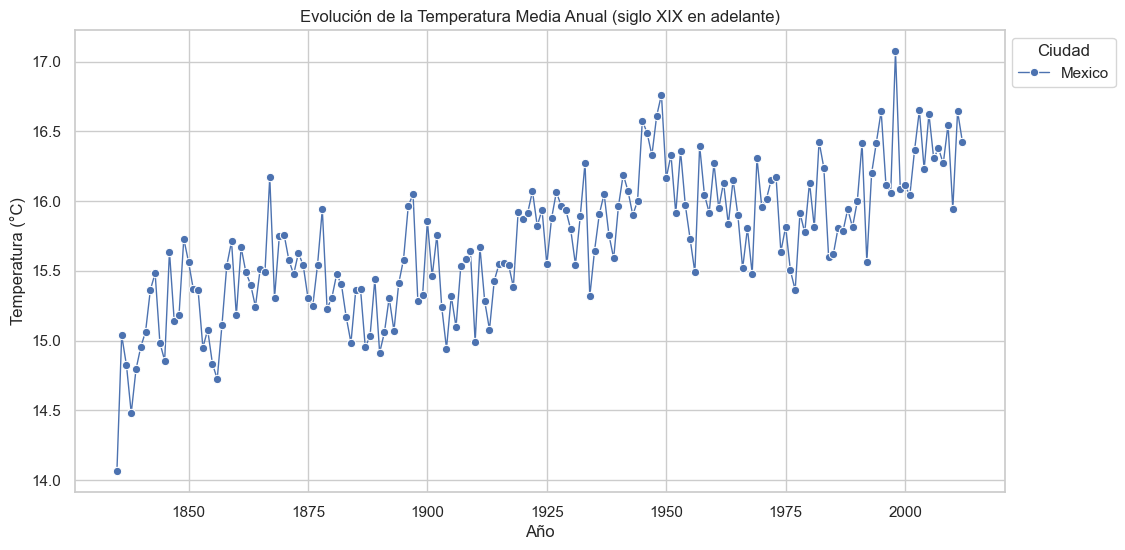

In [206]:
ciudades_filtro = ['Montreal', 'Toronto', 'Moscow']
ciudades_filtro = ['Mexico']

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long[df_long['city'].isin(ciudades_filtro)], x="year", y="temperature", hue="city", linewidth=1, marker='o')

plt.title("Evolución de la Temperatura Media Anual (siglo XIX en adelante)")
plt.xlabel("Año")
plt.ylabel("Temperatura (°C)")
# plt.ylim(0,31)
plt.legend(title="Ciudad", loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

La estrategia a utilizar para conocer el Top 5 de las ciudades donde el cambio climático ha sido más pronunciado desde el siglo XIX será la siguiente:

1) Obtener la temperatura más antigua.

2) Obtener la temperatura más reciente.

3) Calcular la diferencia de temperaturas:
    $$\Delta T= \text{Temperatura}_{\text{ reciente}}-\text{Temperatura}_{\text{ antigua}}$$

4) Ordernar las ciudades por mayor aumento de temperatura.

5) Tomar el Top 5 con mayor diferencia.

In [185]:
# Agrupamos por ciudad y obtenemos el año más antiguo y el más reciente
df_diff_temp = df_long.groupby('city').agg(
    min_year = ('year', 'min'),
    max_year = ('year', 'max')
).reset_index()

# DataFrame con las temperaturas mínimas por ciudad
temp_min = df_long.loc[df_long.groupby('city')['year'].idxmin(), ['city', 'temperature']]

# DataFrame con las temperaturas máximas por ciudad
temp_max = df_long.loc[df_long.groupby('city')['year'].idxmax(), ['city', 'temperature']]

# Hacemos inner join 
df_diff_temp = df_diff_temp.merge(temp_min, on='city').rename(columns={'temperature': 'temp_min'})
df_diff_temp = df_diff_temp.merge(temp_max, on='city').rename(columns={'temperature': 'temp_max'})

# Calculamos la diferencia en temperaturas
df_diff_temp['delta_T'] = df_diff_temp['temp_max'] - df_diff_temp['temp_min']

# Visualización de las primeras 3 filas
df_diff_temp.head(3)

,city,min_year,max_year,temp_min,temp_max,delta_T
0,Abidjan,1849,2012,25.536208,26.800083,1.263875
1,Addis Abeba,1850,2012,16.827792,18.419083,1.591292
2,Ahmadabad,1817,2012,25.227583,27.027250,1.799667


In [189]:
# Top 5
top_5 = df_diff_temp.sort_values(by='delta_T', ascending=False).head(5)

# Visualización
top_5[['city','delta_T']]

,city,delta_T
6,Baghdad,4.903604
96,Toronto,4.705167
71,New York,4.520083
64,Montreal,4.487125
81,Santiago,4.244917


Hemos encontrado que el Top 5 de las ciudades donde el cambio climático ha sido más pronunciado desde el siglo XIX es:

Ordenados de primer a quinto lugar:
* Baghdad
* Toronto
* New York
* Montreal
* Santiago

Ahora, dividiremos los datos en periodos de 5, 10 y 25 años con tal de observar el cambio de la temperatura media por ciudad.

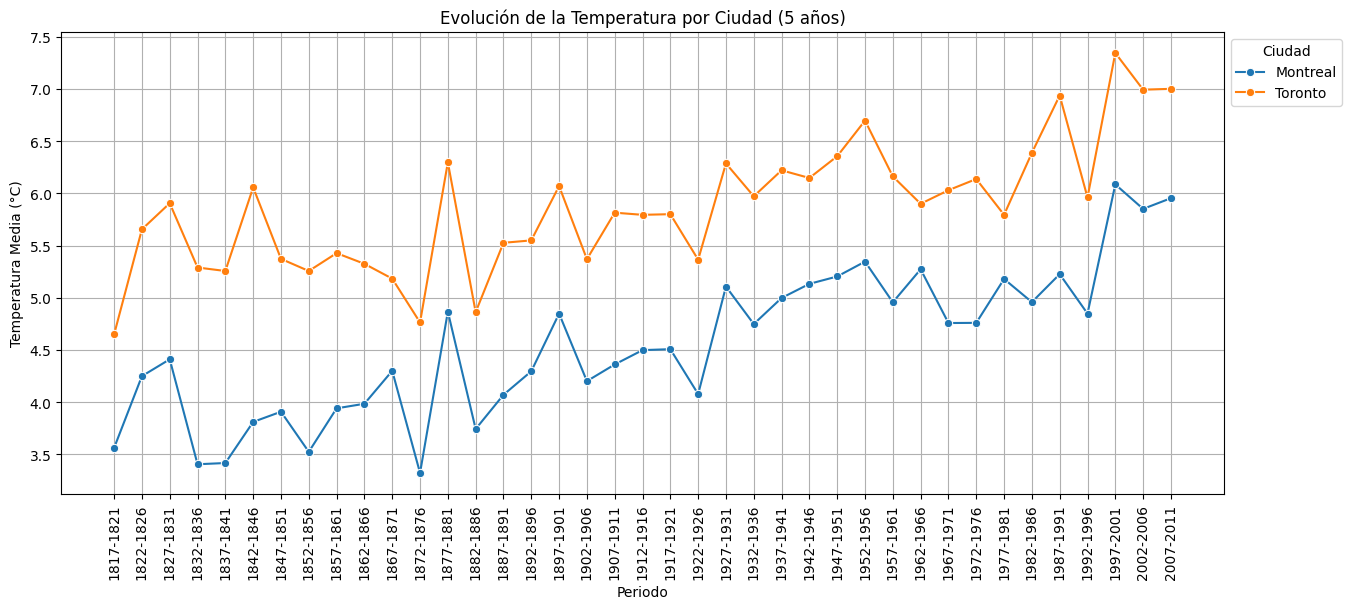

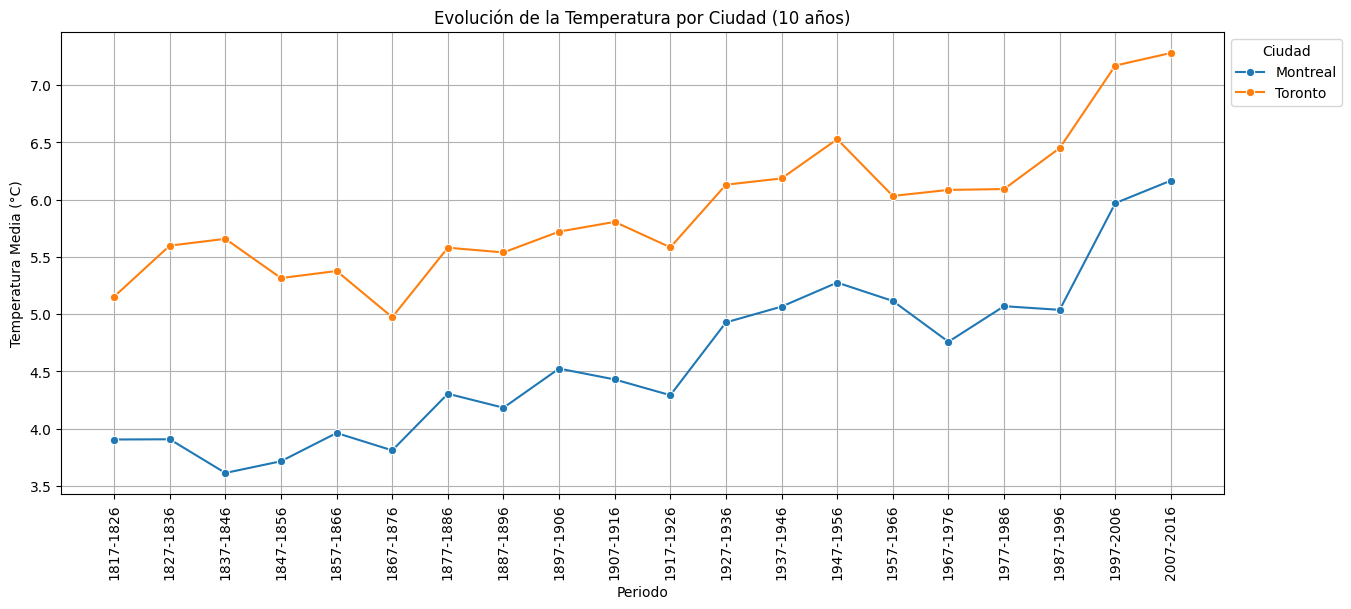

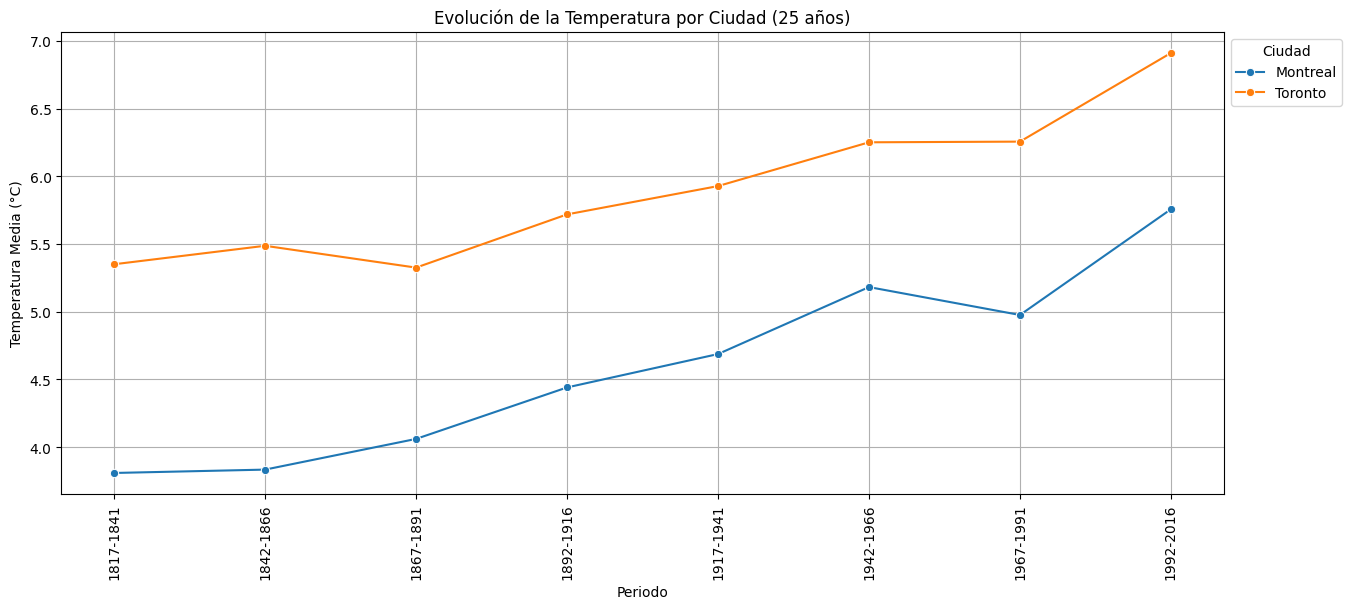

In [97]:
# DEFINIR PERÍODOS (5, 10, 25 años)
periodos = [5, 10, 25]

# CREAR GRÁFICOS PARA CADA PERIODO
for periodo in periodos:
    # Crear intervalos de tiempo
    min_year, max_year = df_long["year"].min(), df_long["year"].max()
    bins = list(range(min_year, max_year + periodo, periodo))
    labels = [(f"{bins[i]}-{bins[i+1]-1}") for i in range(len(bins)-1)]

    # Asignar cada año a un intervalo
    df_long[f"Periodo_{periodo}"] = pd.cut(df_long["year"], bins=bins, labels=labels, right=False)

    # Calcular la temperatura media por período y ciudad
    df_grouped = df_long.groupby(["city", f"Periodo_{periodo}"], observed=True)["temperature"].mean().reset_index()

    # GRAFICAR
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_grouped[df_grouped['city'].isin(['Toronto','Montreal'])], x=f"Periodo_{periodo}", y="temperature", hue="city", marker="o")
    plt.title(f"Evolución de la Temperatura por Ciudad ({periodo} años)")
    plt.xlabel("Periodo")
    plt.ylabel("Temperatura Media (°C)")
    plt.xticks(rotation=90)
    plt.legend(title="Ciudad", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

In [101]:
df_long

,city,year,temperature,Periodo_5,Periodo_10,Periodo_25
0,Abidjan,1849,25.536208,1847-1851,1847-1856,1842-1866
1,Ahmadabad,1849,26.092083,1847-1851,1847-1856,1842-1866
2,Aleppo,1849,16.992500,1847-1851,1847-1856,1842-1866
3,Alexandria,1849,20.082625,1847-1851,1847-1856,1842-1866
4,Ankara,1849,10.095583,1847-1851,1847-1856,1842-1866
...,...,...,...,...,...,...
19595,Luanda,1848,NaN,1847-1851,1847-1856,1842-1866
19596,Cape Town,1848,NaN,1847-1851,1847-1856,1842-1866
19597,Durban,1848,NaN,1847-1851,1847-1856,1842-1866
19598,Umm Durman,1848,NaN,1847-1851,1847-1856,1842-1866


Nota: observed puede tomar los booleanes False o True y no afecta el resultado del groupby, pues por la contrucción de los bins que definimos, cada ciudad tendrá la misma categoría de períodos. Con False se obtienen todas las combinaciones entre ciudad-periodo colocando nan en donde no haya una observación (temperatura). Con True solo se eliminan las combinaciones vacías (no hay observacion de temperatura).